In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle
import os
np.set_printoptions(suppress=True)

In [2]:
# This is for hyperparameter tuning
X_train = pd.DataFrame(np.load('data/X_train.npz')['X_train'])
X_val = pd.DataFrame(np.load('data/X_val.npz')['X_val'])

y_train = np.load('data/y_train.npz')['y_train']
y_val = np.load('data/y_val.npz')['y_val']

# This is for training the final models
X = X_train.append(X_val)
y = np.append(y_train, y_val)

In [3]:
def rmse(*args):
    """ Funcion that calculates the root mean squared error"""
    return np.sqrt(mean_squared_error(*args))
def clip20(x):
    return np.clip(x, 0, 20)

## Stacking approach

The final model will be an ensemble that uses the stacking approach.

So there will be 3 **base models**:
- Light Gradient Boosting (lightgbm)
- XGBoost
- Random Forest

And the meta-model will be a **Linear Regression**

## Metrics

The metric that's being used is "RMSE" because that's what has to be optimized in the final model.

## Hyperparameter Tuning

### A. Light Gradient Boosting

This is done so as to find the best parameters of the "lightgbm" model.

Here I find the best learning rate by training and validating.  
An RMSE is computed after clipping the 'y' values because that's how the results will be evaluated in the leaderboard.

In [4]:
learning_rates = [0.02, 0.03, 0.04, 0.06, 0.08]
best_rmse = 9999999999999
for lr in learning_rates:
    lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': lr, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
               'num_threads':-1,
              }

    lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), int(100 * (lr / 0.03)))
    pred_lgb_val = lgb_model.predict(X_val)
    score = rmse(clip20(y_val), clip20(pred_lgb_val))
#     score = rmse(y_val, pred_lgb_val)

    if score < best_rmse:
        best_rmse = score
        best_lr = lr
        print('learning_rate: {}, best_rmse: {}'.format(lr, best_rmse))
        best_lgb = lgb_model

learning_rate: 0.02, best_rmse: 0.6828520758559177
learning_rate: 0.03, best_rmse: 0.6590592464576364
learning_rate: 0.04, best_rmse: 0.6520837032435529
learning_rate: 0.06, best_rmse: 0.6483975421875632
learning_rate: 0.08, best_rmse: 0.6481935464006291


#### Final training

In [5]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': best_lr, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
               'num_threads':-1,
              }
best_lgb = lgb.train(lgb_params, lgb.Dataset(X, label=y), 100)

In [6]:
pred_lgb_val = best_lgb.predict(X_val)
pred_lgb_val = clip20(pred_lgb_val)
np.savetxt('output/pred_lgb_val.csv', pred_lgb_val, delimiter=",")
print(pred_lgb_val.mean())

print('Train RMSE %f' % rmse(clip20(y_train), clip20(lgb_model.predict(X_train))))
print('Val RMSE %f' % rmse(clip20(y_val), clip20(pred_lgb_val)))

0.29964386181944747
Train RMSE 0.664622
Val RMSE 0.573259


In [7]:
filename = 'models/best_lgb.pkl'
pickle.dump(best_lgb, open(filename, 'wb'))

## Feature Importance

This is to check if features really contribute to the model.

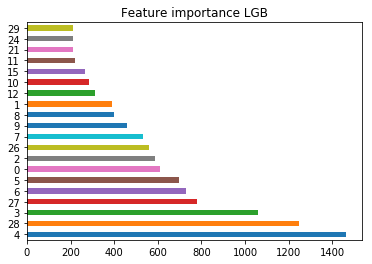

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline 

feat_importances = pd.Series(best_lgb.feature_importance(), index=X_val.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.title('Feature importance LGB')
plt.show()

### B. XGBoost

Here I do a randomized grid search so that it ends faster.

In [9]:
train_ind=np.zeros(X.shape[0])
for i in range(0, len(X_train)):
    train_ind[i] = -1
ps = PredefinedSplit(test_fold=(train_ind))

In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# A parameter grid for XGBoost
params = {'min_child_weight':[4,5],
          'gamma':[i/10.0 for i in range(3,5)],
          'subsample':[i/10.0 for i in range(6,8)],
          'colsample_bytree':[i/10.0 for i in range(6,8)],
          'max_depth': [2,3]}

# Initialize XGB and GridSearch
xgb_model = XGBRegressor(n_jobs=-1, eval_metric='rmse')

best_xgb = RandomizedSearchCV(xgb_model, params, verbose=3, n_jobs=-1, cv=ps)
best_xgb.fit(X, y, verbose=True)

# best_xgb = XGBRegressor(random_state=100,
#                      n_estimators=30,
#                      max_depth=10,
#                      n_jobs=4,
#                      eval_metric='rmse')
# best_xgb.fit(X, y, verbose=True)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV] subsample=0.6, min_child_weight=5, max_depth=2, gamma=0.3, colsample_bytree=0.7 
[CV] subsample=0.7, min_child_weight=4, max_depth=2, gamma=0.3, colsample_bytree=0.7 
[CV] subsample=0.6, min_child_weight=4, max_depth=2, gamma=0.3, colsample_bytree=0.7 
[CV] subsample=0.6, min_child_weight=4, max_depth=2, gamma=0.4, colsample_bytree=0.7 
[CV]  subsample=0.6, min_child_weight=5, max_depth=2, gamma=0.3, colsample_bytree=0.7, score=0.5221274208956375, total= 3.4min
[CV] subsample=0.6, min_child_weight=5, max_depth=3, gamma=0.4, colsample_bytree=0.7 
[CV]  subsample=0.6, min_child_weight=4, max_depth=2, gamma=0.3, colsample_bytree=0.7, score=0.5239899509915009, total= 3.4min
[CV] subsample=0.6, min_child_weight=5, max_depth=3, gamma=0.3, colsample_bytree=0.6 
[CV]  subsample=0.7, min_child_weight=4, max_depth=2, gamma=0.3, colsample_bytree=0.7, score=0.5141285048371886, total= 3.4min
[CV] subsample=0.6, min_child_weight=4, ma

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  7.8min remaining:  3.3min


[CV]  subsample=0.6, min_child_weight=5, max_depth=3, gamma=0.4, colsample_bytree=0.7, score=0.5405476842425396, total= 4.6min
[CV]  subsample=0.7, min_child_weight=4, max_depth=2, gamma=0.4, colsample_bytree=0.7, score=0.5141285048371886, total= 2.5min
[CV]  subsample=0.7, min_child_weight=4, max_depth=3, gamma=0.4, colsample_bytree=0.7, score=0.5473960136482483, total= 3.4min


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.2min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
          error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'min_child_weight': [4, 5], 'gamma': [0.3, 0.4], 'subsample': [0.6, 0.7], 'colsample_bytree': [0.6, 0.7], 'max_depth': [2, 3]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=3)

In [11]:
pred_xgb_val = best_xgb.predict(X_val)
pred_xgb_val = clip20(pred_xgb_val)
np.savetxt('output/pred_xgb_val.csv', pred_xgb_val, delimiter=",")
print(pred_xgb_val.mean())

print('Train RMSE %f' % rmse(clip20(y_train), clip20(best_xgb.predict(X_train))))
print('Val RMSE %f' % rmse(clip20(y_val), clip20(pred_xgb_val)))

0.3412288
Train RMSE 0.903240
Val RMSE 0.739043


In [12]:
filename = 'models/best_xgb.pkl'
pickle.dump(best_xgb, open(filename, 'wb'))

### B. Random Forest

Trained with an increased "min_samples_leaf" because it's been overfitting.

In [13]:
from sklearn.ensemble import RandomForestRegressor

params={'max_features':[4, 6, 8], 
        'max_depth': [2, 8],
        'min_samples_leaf' : [8, 16, 20]}

rf_model = RandomForestRegressor(n_estimators=16, n_jobs=-1, random_state=100, criterion='mse', verbose=2)
best_rf = RandomizedSearchCV(rf_model, params, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=2, cv=ps)
best_rf.fit(X, y)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV] min_samples_leaf=16, max_features=6, max_depth=2 ................
[CV] min_samples_leaf=16, max_features=6, max_depth=8 ................
building tree 1 of 16
building tree 3 of 16
building tree 2 of 16
building tree 4 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
[CV] min_samples_leaf=20, max_features=8, max_depth=2 ................
building tree 2 of 16
building tree 4 of 16
building tree 3 of 16
building tree 1 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
[CV] min_samples_leaf=20, max_features=8, max_depth=8 ................
building tree 1 of 16
building tree 4 of 16
building tree 2 of 16
building tree 3 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16
building tree 5 of 16
building tree 7 of 16
building tree 6 of 16
building tree 4 of 16
building tree 2 of 16
building t

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   12.6s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.3s finished


[CV] . min_samples_leaf=16, max_features=6, max_depth=2, total=  14.6s
[CV] min_samples_leaf=16, max_features=8, max_depth=2 ................
building tree 9 of 16
building tree 5 of 16
building tree 10 of 16
building tree 11 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 12 of 16
building tree 4 of 16
building tree 1 of 16
building tree 2 of 16
building tree 3 of 16
building tree 13 of 16
building tree 15 of 16
building tree 14 of 16
building tree 16 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   22.1s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished


building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 5 of 16
building tree 9 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.3s finished


[CV] . min_samples_leaf=20, max_features=8, max_depth=2, total=  28.2s
building tree 6 of 16
building tree 7 of 16
[CV] min_samples_leaf=8, max_features=8, max_depth=2 .................
building tree 10 of 16
building tree 12 of 16
building tree 11 of 16
building tree 8 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16
building tree 3 of 16
building tree 2 of 16
building tree 4 of 16
building tree 1 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   21.8s finished


building tree 5 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished


building tree 6 of 16
building tree 7 of 16
building tree 8 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.3s finished


[CV] . min_samples_leaf=16, max_features=8, max_depth=2, total=  28.1s
[CV] min_samples_leaf=8, max_features=6, max_depth=8 .................
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 13 of 16
building tree 14 of 16
building tree 12 of 16
building tree 15 of 16
building tree 16 of 16
building tree 9 of 16
building tree 1 of 16
building tree 2 of 16
building tree 4 of 16
building tree 3 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   23.3s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.3s finished


[CV] .. min_samples_leaf=8, max_features=8, max_depth=2, total=  29.7s
[CV] min_samples_leaf=16, max_features=8, max_depth=8 ................


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.1min finished


building tree 5 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.4s finished


building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 3 of 16
building tree 2 of 16
building tree 4 of 16
building tree 1 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.1s finished


[CV] . min_samples_leaf=16, max_features=6, max_depth=8, total= 1.1min
[CV] min_samples_leaf=16, max_features=4, max_depth=8 ................
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16
building tree 3 of 16
building tree 1 of 16
building tree 2 of 16
building tree 4 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 5 of 16
building tree 6 of 16
building tree 5 of 16
building tree 7 of 16
building tree 8 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.5min finished


building tree 9 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.7s finished


building tree 10 of 16
building tree 11 of 16
building tree 13 of 16
building tree 14 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.3s finished


[CV] . min_samples_leaf=20, max_features=8, max_depth=8, total= 1.7min
building tree 12 of 16
[CV] min_samples_leaf=20, max_features=4, max_depth=2 ................
building tree 15 of 16
building tree 16 of 16
building tree 3 of 16
building tree 2 of 16
building tree 1 of 16
building tree 4 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 13 of 16
building tree 8 of 16
building tree 12 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   17.7s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.5s finished


[CV] . min_samples_leaf=20, max_features=4, max_depth=2, total=  25.7s


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   58.5s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.9s finished


[CV] .. min_samples_leaf=8, max_features=6, max_depth=8, total= 1.5min


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.3s finished


building tree 13 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.7s finished


[CV] . min_samples_leaf=16, max_features=4, max_depth=8, total= 1.1min
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.4s finished


[CV] . min_samples_leaf=16, max_features=8, max_depth=8, total= 1.4min


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.6min finished


building tree 1 of 16building tree 2 of 16building tree 3 of 16
building tree 4 of 16


building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   34.7s finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
          error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=-1,
           oob_score=False, random_state=100, verbose=2, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'max_features': [4, 6, 8], 'max_depth': [2, 8], 'min_samples_leaf': [8, 16, 20]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [14]:
pred_rf_val = best_rf.predict(X_val)
pred_rf_val = clip20(pred_rf_val)
np.savetxt('output/pred_rf_val.csv', pred_rf_val, delimiter=",")
print(pred_rf_val.mean())

print('Train RMSE %f' % rmse(clip20(y_train), clip20(best_rf.predict(X_train))))
print('Val RMSE %f' % rmse(clip20(y_val), clip20(pred_rf_val)))

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished


0.33545645343144237
Train RMSE 0.898301
Val RMSE 0.702159


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.4s finished


In [15]:
filename = 'models/best_rf.pkl'
pickle.dump(best_rf, open(filename, 'wb'))